# Introduction



In this notebook, we will 
- Learn how to use BoostedTrees Classifier for training and evaluating
- Explore how training can be speeded up for small datasets
- Will develop intuition for how some of the hyperparameters affect the performance of boosted trees.


In [1]:
# We will use some np and pandas for dealing with input data.
import numpy as np
import pandas as pd
# And of course, we need tensorflow.
import tensorflow as tf

from distutils.version import StrictVersion

In [2]:
tf.__version__

'1.13.1'

# Load dataset
We will be using the titanic dataset, where the goal is to predict passenger survival given characteristiscs such as gender, age, class, etc.

In [3]:
tf.logging.set_verbosity(tf.logging.INFO)
tf.set_random_seed(123)

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [4]:
fcol = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

def one_hot_cat_column(feature_name, vocab):
  return fcol.indicator_column(
      fcol.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
fc = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  fc.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  fc.append(fcol.numeric_column(feature_name,
                                dtype=tf.float32))

In [5]:
# Prepare the input fn. Use the entire dataset for a batch since this is such a small dataset.

def make_input_fn(X, y, n_epochs=None, do_batching=True):
  def input_fn():
    BATCH_SIZE = len(y)
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    # For training, cycle thru dataset as many times as need (n_epochs=None).    
    dataset = dataset.repeat(n_epochs)  
    if do_batching:
      dataset = dataset.batch(BATCH_SIZE)
    return dataset
  return input_fn

# Training and Evaluating Classifiers

In [6]:
TRAIN_SIZE = len(dftrain)
params = {
  'n_trees':10,
  'center_bias':False,
  'l2_regularization':1./TRAIN_SIZE # regularization is per instance, so if you are familiar with XGBoost, you need to divide these values by the num of examples per layer
}


Train and evaluate the model. We will look at accuracy first.


In [7]:
# Training and evaluation input functions.
n_batches_per_layer = 1  # Use one batch, consisting of the entire dataset to build each layer in the tree.
DO_BATCHING = True

train_input_fn = make_input_fn(dftrain, y_train, n_epochs=None, do_batching=DO_BATCHING)
eval_input_fn = make_input_fn(dfeval, y_eval, n_epochs=1, do_batching=DO_BATCHING)
est = tf.estimator.BoostedTreesClassifier(fc,
                                          n_batches_per_layer=n_batches_per_layer,
                                          **params)

est.train(train_input_fn)

# Eval.
pd.Series(est.evaluate(eval_input_fn))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3414de5c10>, '_model_dir': '/tmp/tmpaS1MMn', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for up

accuracy                 0.806818
accuracy_baseline        0.625000
auc                      0.866330
auc_precision_recall     0.850316
average_loss             0.419913
global_step             60.000000
label/mean               0.375000
loss                     0.419913
precision                0.750000
prediction/mean          0.385222
recall                   0.727273
dtype: float64

DNN classifier.

In [11]:
# Training and evaluation input functions.
est = tf.estimator.DNNClassifier([10], fc)
est.train(train_input_fn, max_steps=1000)
pd.Series(est.evaluate(eval_input_fn))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f34437d2610>, '_model_dir': '/tmp/tmpQ_vHbC', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was 

accuracy                   0.814394
accuracy_baseline          0.625000
auc                        0.844965
auc_precision_recall       0.796831
average_loss               0.483871
global_step             1000.000000
label/mean                 0.375000
loss                     127.741821
precision                  0.740385
prediction/mean            0.407504
recall                     0.777778
dtype: float64

## Improving the performance

**???** Can you get better performance out of the classifier?  What parameters the boosted trees are most sensitive to?

**???** Can you see if Boosted trees can overfit? How can you demonstrate it?


# Results

Let's understand how our model is performing.

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmphU4KBq/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


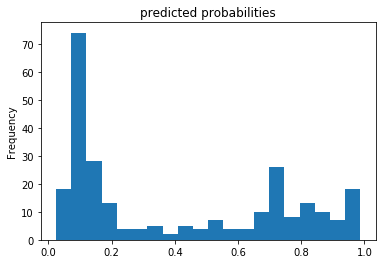

In [9]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities');

**???** Why are the probabilities right skewed?

Let's plot an ROC curve to understand model performance for various predicition probabilities.

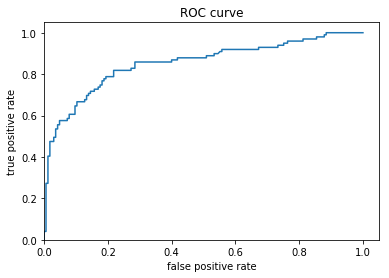

In [10]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,);

**???** What does true positive rate and false positive rate refer to for this dataset?

Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License